In [1]:
## This notebook describes how to generate the data used to model the instrument:
## * focal plane
## * pointing model parameters of the telescope
## * beam parameters of the bolometers
## * polarisation angle of the bolometers
## * Half-wave plate (continously rotated or stepped)

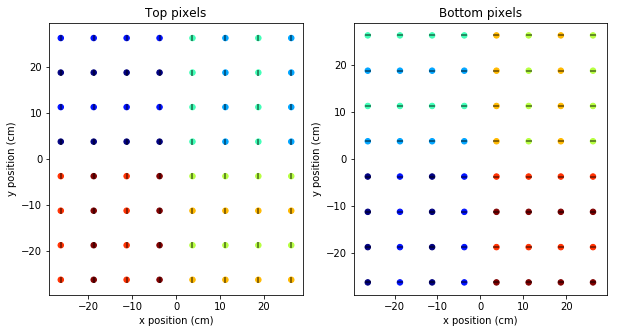

In [2]:
## Include the path to instrument
import sys
import os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))

## See http://simonsobservatory.wikidot.com/instrument-systmodule for more informations.
from s4cmb import instrument
from s4cmb.instrument import show_focal_plane
import numpy as np

## Generate a focal plane with 4 Crate boards, each with 1 MUX board, 
## each with 1 Squid, each with 16 pairs of bolometers.
## The focal plane is 60 cm wide (square),
## and each detector beam is Gaussian with FWHM of 3.5 arcmin.
inst = instrument.Hardware(ncrate=4, ndfmux_per_crate=1,
                           nsquid_per_mux=1, npair_per_squid=16,
                           fp_size=60., FWHM=3.5, 
                           beam_seed=58347, projected_fp_size=3., pm_name='5params',
                           type_HWP='CRHWP', freq_HWP=2., angle_HWP=0., verbose=False)

## Let's have a look at our wonderful focal plane.
fp = inst.focal_plane
show_focal_plane(fp.bolo_xcoord, fp.bolo_ycoord, fp.bolo_polangle, save_on_disk=False, display=True)

In [3]:
## The colorcode corresponds to the value of the polarisation angle.
## The polarisation angle model consists in defining detector polarisation
## angle. The focal plane is cut in quadrants (Crate).
## Within a quadrant, pixels are categorized into two: Q and U pixels.
## Q and U pixels have 45 degrees difference in their polarisation angle,
## and form lines within quadrant. Each pixel contains a top and a
## bottom bolometer, with 90 degrees difference in the polarisation angle.
## Then, you go from one quadrant to another by a global 90 deg rotation
## of the polarisation angle starting with quadrant 0 having
## theta_{Q, top} = 0 deg.

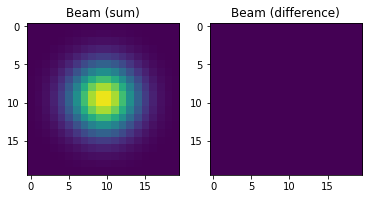

In [4]:
## Let's have a look at our beam parameters now
## Let's plot the resulting beam map for a pixel in the focal plane
import pylab as pl
from s4cmb.instrument import construct_beammap
beam = inst.beam_model
summap, diffmap = construct_beammap(beam, 0, 1, 20, 0.5 / 180. * np.pi / 60.)
fig, ax = pl.subplots(1,2)
ax[0].imshow(summap, vmin=0, vmax=1)
ax[0].set_title('Beam (sum)')
ax[1].imshow(diffmap, vmin=0, vmax=1e-10)
ax[1].set_title('Beam (difference)')
pl.show()

In [5]:
## As expected, the difference beam is zero (the two detector beams are identical for the moment)
## We will see later how to perturbed the beams, and generate spurious signals from beam mismatch.

In [6]:
## We also have access to the pointing model of the telescope
## We focus on a five-parameter pointing model (Mangum 2001) to
## characterize the relationship between the telescope's encoder
## readings and its true boresight pointing on the sky.
## The parameters described in this reference are
##
##  * IA, the azimuth encoder zero offset,
##  * IE, the elevation encoder zero offset,
##  * CA, the collimation error of the electromagnetic axis,
##  * AN, the azimuth axis offset/misalignment (north-south) and
##  * AW, the azimuth offset/misalignment (east-west).
pm = inst.pointing_model
[(i, round(j,3)) for i, j in zip(pm.allowed_params.split(), pm.value_params)]

[('ia', -10.285), ('ie', 8.74), ('ca', -15.598), ('an', -0.51), ('aw', 0.109)]

In [7]:
## Finally, one can add a Half-Wave Plate (HWP) to our instrument. 
## There are two types of HWP available: continously rotated or stepped
## Below, we initialise our instrument with the former.
hwp = inst.half_wave_plate
hwp.type_HWP, hwp.freq_HWP, 'Hz', hwp.angle_HWP, 'deg'

('CRHWP', 2.0, 'Hz', 0.0, 'deg')

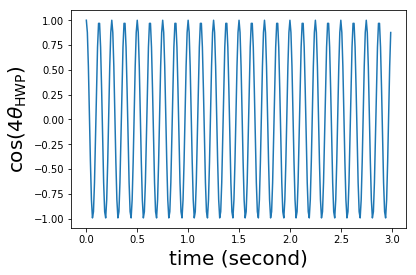

In [8]:
## One can easily generate HWP angles which can be use later to generate timestreams.
sample_rate, size = 100., 300
hwp_angles = hwp.compute_HWP_angles(sample_rate=sample_rate, size=size)
xaxis = [t/sample_rate for t in range(size)]
pl.plot(xaxis, np.cos(4*hwp_angles), ls='-')
pl.xlabel('time (second)', fontsize=20)
pl.ylabel('cos(4$\\theta_{\\rm{HWP}}$)', fontsize=20)
pl.show()

In [9]:
## Note that the routine compute_HWP_angles() returns increasing value of the angle, that is values not
## between 0 and 2pi. So if needed, you have to clip values first.
print(hwp_angles[::20] * 180. / np.pi)
print(hwp_angles[::20] % (2 * np.pi) * 180. / np.pi)

[    0.   144.   288.   432.   576.   720.   864.  1008.  1152.  1296.
  1440.  1584.  1728.  1872.  2016.]
[   0.  144.  288.   72.  216.    0.  144.  288.   72.  216.    0.  144.
  288.   72.  216.]


In [10]:
## A stepped HWP is easily generated by setting the frequency of rotation to zero.
## Alternatively, one can update the behaviour of the HWP on-the-fly.
hwp.update_hardware(new_type_HWP='stepped', new_freq_HWP=0.0, new_angle_HWP=20.0)
hwp_angles = hwp.compute_HWP_angles(sample_rate=sample_rate, size=size)
print hwp_angles[:10] * 180. / np.pi

[ 20.  20.  20.  20.  20.  20.  20.  20.  20.  20.]


In [11]:
## It can be useful to simulate hardware problems over some period of time for example!